<a href="https://colab.research.google.com/github/phantom-balance/HybridEnergy/blob/master/solar_phs_gasifier_PO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!pip install pymoo
!pip install brewer2mpl
!pip install matplotlib
clear_output()

In [2]:
import matplotlib.pyplot as plt
# Set the global font and text parameters for plots
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams['font.size'] = 12
plt.rcParams['text.color'] = 'black'

# Function to set the plot style
def set_plot_style(ax):
    # Set the border color to black
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
# Set linewidth for spines
    ax.spines['top'].set_linewidth(1.3)
    ax.spines['bottom'].set_linewidth(1.3)
    ax.spines['left'].set_linewidth(1.3)
    ax.spines['right'].set_linewidth(1.3)

    # Set tick color and width
    ax.tick_params(axis='both', direction='in', width=1.5, colors='black')

In [4]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymoo
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

# reading the hourly energy csv file "contains hourly data for deficits, solar radiation and ambient air temperature(Jumla)"
df = pd.read_csv('HOURLY_DATA_new.csv')
df = df[0:100]
'''
     csv file has deficit energy in MWh, solar radiation(ghi) in W/m2, air temperature in celcius.
    We perform the analysis in terms of KW.
'''
df['deficit_energy']=df['deficit_energy']*1000
df['deficit_energy'] = df['deficit_energy'].apply(lambda x: round(x, 6))
df['ghi']=df['ghi']/1000

'''
    All the necessary constants required for modeling.
'''
N = 20 # project_life
i = 0.06 # interest_rate

solar_cost_unit = 727 # usd/kW(capex)
solar_OM = 4 # usd/kW.year(opex)

CRF = (i*((1+i)**N))/(((1+i)**N)-1) # capital recovery factor
d_f = 0.88 #derating_factor
Gt_stc = 1 #kw/m2
ap = -0.0035 #solar mod temp coeff of power(%/oC)
T_cstc = 25 #oC standard temp
NOCT = 45 #oC
n_bat = 0.92 #round trip efficieny

gasifier_cost_unit = 2300 # usd/kW(capex)
gasifier_OM = 2 # usd/kW.year(opex)
gasifier_CUF = 0.55 # capacity utilization factor

pump_cost_unit = 1075 #usd/kW
pump_OM = 0.01075 #usd/kW.year

reservoir_cost_unit = 170 #usd/m2
reservoir_OM = 1.7 #usd/m3.year

turbine_cost_unit = 1000 #usd/kw
turbine_OM = 0.01 #usd/kw

#single site phs(1GWh)
reservoir_max = 10000000 #m3
reservoir_area = 5000000 #m2
h3 = 50 #m(minimum head)
h2_max = reservoir_max/reservoir_area #maximum reservior head
density = 1000 #kg/m3(water)
g = 9.8 #m/s2
ntur = 0.7 #efficiency of turbine
npum = 0.7 #efficiency of pump

Q_res = reservoir_max/3600
turbine_max = Q_res*density*g*(h3+h2_max)*ntur/1000
pump_max = Q_res*density*g*(h3+h2_max)*npum/1000

'''
    Calculating the cost of the hybrid energy system.
'''
def cost_pv(solar):
  solar_cost = solar*((CRF*solar_cost_unit)+solar_OM)
  # print(solar_cost)
  return solar_cost

def cost_gasifier(gasifier):
  gasifier_cost = gasifier*((CRF*gasifier_cost_unit)+gasifier_OM)
  # print(gasifier_cost)
  return gasifier_cost

def cost_pump(pump):
  pump_cost_woelec = pump*((CRF*pump_cost_unit)+pump_OM)
  # pump_elec_op = pump_elec*0.04*CRF
  pump_cost = pump_cost_woelec#+pump_elec_op
  return pump_cost

def cost_reservoir(reservoir_vol):
  reservoir_cost = reservoir_area*reservoir_cost_unit*CRF + reservoir_vol*reservoir_OM
  return reservoir_cost

def cost_turbine(turbine):
  turbine_cost = turbine*((CRF*turbine_cost_unit)+turbine_OM)
  return turbine_cost

def LCOE(total_energy_prod, solar, gasifier, pump, reservoir, turbine):
  ASC = cost_pv(solar)+cost_gasifier(gasifier)+cost_pump(pump)+cost_reservoir(reservoir)+cost_turbine(turbine)
  energy_prod_per_year = total_energy_prod/N
  LCOE = ASC/energy_prod_per_year
  return ASC, LCOE

'''
    Calculating the energy produced by the solar panel and gasifier.
'''
def solar_ene_prod(solar_rate, solar_rad, temp):
  T_cell = temp+Gt_stc*((NOCT-20)/0.8)
  p_op = solar_rate*d_f*(solar_rad/Gt_stc)*(1+ap*(T_cell-T_cstc))
  return p_op

def gasifier_ene_prod(gasifier_rate):
  return gasifier_rate*gasifier_CUF

def turbine_energy(turbine, reservior_lev):
  'maximum energy produced by phs turbine'
  Qt_rated = turbine*1000/(density*g*(h3+h2_max)*ntur) # turbine throughput
  res_Qt = reservior_lev/3600 #maximum Qt available from reservior
  Qt = min(Qt_rated, res_Qt)
  energy_prod = Qt*ntur*density*g*(h3+(reservior_lev/reservoir_area))
  return energy_prod/1000

def turbine_discharge(energy, reservior_lev):
  Qdis = energy*1000/(ntur*density*g*(h3+(reservior_lev/reservoir_area)))
  Qdis_hr = Qdis*3600
  return Qdis_hr

def pump_energy(pump, Pch_t, reservior_lev):
  Qp_rated = pump*1000/(density*g*(h3+h2_max)*npum) # pump throughput
  res_Qp = (reservoir_max-reservior_lev)/3600 #maximum Qp available from reservior
  Qp = min(Qp_rated, res_Qp)
  Ep = Qp*density*g*(h3+reservior_lev/reservoir_area)/npum
  Edump = 0
  Ep = Ep/1000
  if Ep>=Pch_t:
    Ep = Pch_t
    Edump = 0
  else:
    Ep = Ep
    Edump = Pch_t-Ep
  return Ep, Edump

def pump_discharge(energy, reservoir_lev):
  energy = energy*1000
  Qdis = npum*energy/(density*g*(h3+(reservoir_lev/reservoir_area)))
  Qdis_hr = Qdis*3600
  return Qdis_hr

'''
    Hybrid Energy system operational strategy
'''
def Energy_prod_(energy_def, reservoir_lev, reservoir_max, pump, turbine,  solar_rate, solar_rad, gasifier_rate, temp):
  energy_def=-energy_def
  energy_prod = 0
  energy_served = 0
  solar_energy = 0
  gasifier_energy = 0
  reservoir_lev_up = reservoir_lev
  turbine_supply = 0


  solar_energy = solar_ene_prod(solar_rate, solar_rad, temp)
  if energy_def>0:
    '''
    Energy deficit strategy
    '''
    if solar_energy-energy_def<0:
      '''
      Solar cannot fulfill the energy deficit.
      Run PHS and gasifier.
      '''
      # req_energy needs to be addressed by gasifier and fuelcell
      req_energy = energy_def-solar_energy
      energy_served+=solar_energy

      if reservoir_lev>0:
        if req_energy<=(turbine_energy(turbine, reservoir_lev)):
          '''
          req_energy met by only fuelcell
          '''
          turbine_supply = req_energy
          energy_served+=turbine_supply
          reservoir_lev_up = reservoir_lev-turbine_discharge(turbine_supply, reservoir_lev)

        else:
          '''
          req_energy met by fuelcell and gasifier
          '''
          gasifier_E_req = req_energy-(turbine_energy(turbine, reservoir_lev))
          turbine_supply = turbine_energy(turbine, reservoir_lev)
          energy_served+=turbine_supply
          reservoir_lev_up = reservoir_lev-turbine_discharge(turbine_supply, reservoir_lev)
          gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

          if gasifier_energy_op>gasifier_E_req:
            gasifier_energy = gasifier_E_req
            energy_served+=gasifier_energy

          else:
            pass
            '''
            Hybrid energy system cannot fulfill the energy deficit.
            New hybrid combination required.
            '''
            # print("# THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")

      else:
        '''
        req_energy met only by gasifier
        '''
        gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

        if req_energy<gasifier_energy_op:
          gasifier_energy = req_energy
          energy_served+=gasifier_energy
        else:
          pass
          '''
          Hybrid energy system cannot fulfill the energy deficit.
          New hybrid combination required.
          '''
          # print("THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")
    else:
      '''
      Solar can fulfill the energy deficit.
      Extra energy from the solar panel is used in electrolyser for hydrogen production.
      '''
      energy_served+=energy_def  # solar panel served the entire deficit energy
      Pch_t = solar_energy-energy_def  # extra energy from solar used for PHS charge


      Ep, Edump = pump_energy(pump, Pch_t, reservoir_lev)
      reservoir_lev_up = reservoir_lev+pump_discharge(Ep, reservoir_lev)
      energy_served+=Edump

    energy_prod = solar_energy + gasifier_energy

  else :
    '''
    Energy surplus strategy
    '''
    energy_prod=solar_energy+gasifier_energy #solar energy already calculated outside loop
    surplus_ene = abs(energy_def)#make hydrogen from this
    Pch_t = solar_energy-energy_def  # extra energy from solar used for PHS charge


    Ep, Edump = pump_energy(pump, Pch_t, reservoir_lev)

    reservoir_lev_up = reservoir_lev+pump_discharge(Ep, reservoir_lev)
    energy_served+=Edump


  return energy_served, turbine_supply, reservoir_lev_up, solar_energy, gasifier_energy

'''
    Optimization for minimizing the LCOE.
'''
class ProblemWrapper(Problem):
  def _evaluate(self, designs, out, *args, **kwargs):
    res = []
    res1 =[]
    for design in designs:
      # print(design)
      solar, gasifier, pump, turbine = design

      count = 0
      Energy_prod_N = 0 #total energy throughout the project life produced
      reservoir_lev = reservoir_max

      for i in range(len(df)):
        Energy_served, turbine_supply, reservoir_lev, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i], reservoir_lev=reservoir_lev, reservoir_max=reservoir_max, pump=pump, turbine=turbine, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
        Energy_prod_N += Energy_served
        energy_tot = df['deficit_energy'][i]+Energy_served
        energy_tot = round(energy_tot, 4)

        if energy_tot<0 and count!=1:
          count = 1
          break
      asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, pump, reservoir_max, turbine)
      res.append(lcoe)
      res1.append(count)
    out['F']=np.array(res)
    out['H']=np.array(res1)

problem = ProblemWrapper(n_var=4, n_obj=1, n_eq_constr=1, xl=[0, 0, 0, 0], xu=[7440937, 2360000, int(pump_max), int(turbine_max)],vtype=int)

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
algorithm = GA(pop_size=2,
               sampling=IntegerRandomSampling(),
               crossover=SBX(prob=1.0, eta=3.0, vtype=int, repair=RoundingRepair()),
               mutation=PM(prob=1.0, eta=3.0, vtype=int, repair=RoundingRepair()),
               eliminate_duplicate=True)
stop_criteria = ('n_gen', 5)

results = minimize(problem=problem,
                   algorithm=algorithm,
                   termination=stop_criteria,
                   verbose=True,
                   seed=42,
                   save_history=True)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |        2 |  0.000000E+00 |  0.000000E+00 |  2.270210E+02 |  2.116880E+02
     2 |        4 |  0.000000E+00 |  0.000000E+00 |  2.058085E+02 |  1.999290E+02
     3 |        6 |  0.000000E+00 |  0.000000E+00 |  1.999550E+02 |  1.999290E+02
     4 |        8 |  0.000000E+00 |  0.000000E+00 |  1.992288E+02 |  1.985286E+02
     5 |       10 |  0.000000E+00 |  0.000000E+00 |  1.980915E+02 |  1.976545E+02


In [18]:
inv_cost_unit = 300 # usd/kW(capex)
inv_OM = 1 # usd/kW.year(opex)
# inv_cap = np.array(solar_ene_array).max()
def cost_inv(inv):
  inv_cost = inv*((CRF*inv_cost_unit)+inv_OM)
  return inv_cost

N=20
def LCOE_inv(total_energy_prod, inv_cap):
  ASC_inv = cost_inv(inv_cap)
  energy_prod_per_year = total_energy_prod/N
  lcoe_inv = ASC_inv/(energy_prod_per_year)
  return lcoe_inv, ASC_inv

#POST OPTIMIZATION

In [19]:
import pickle
with open('pv-gas-phs_ga-res.pkl', 'rb') as file:
    results_phs = pickle.load(file)

df = pd.read_csv('HOURLY_DATA_new.csv')
df = df[0:24*365*20]
df['deficit_energy']=df['deficit_energy']*1000
df['deficit_energy'] = df['deficit_energy'].apply(lambda x: round(x, 6))
df['ghi']=df['ghi']/1000

In [20]:
'''
Viewing the operation of the optimized hybrid energy system.
'''
solar, gasifier, pump, turbine = results_phs.X
# pump = 3*pump
# solar, gasifier, battery = 3717620.230751795, 2209925.35022830, 4446649.505009017

# Solar:3717620.230751795KW, Gasifier: 2209925.350228307KW, Battery: 4446649.505009017KWh || LCOE: [0.12784646]USD/KWh

solar_array = []
gasifier_array = []
turbine_array = []
deficit_array = []
reservoir_array = []

total_supply = []

count = 0
gasifier_up_hr = 0
gasifier_energy = 0
Energy_prod_N = 0
reservoir_lev = reservoir_max
count = 0
Energy_prod_N = 0 #total energy throughout the project life produced
reservoir_lev = reservoir_max
solar_ene_array = []

for i in range(len(df)):
# for i in range(8760):
  Energy_served, turbine_supply, reservoir_lev, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i], reservoir_lev=reservoir_lev, reservoir_max=reservoir_max, pump=pump, turbine=turbine, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_prod_N += Energy_served
  gasifier_energy+=gasifier_ene
  solar_ene_array.append(solar_ene)

  if round(gasifier_ene, 2)>0:
    gasifier_up_hr+=1

  energy_tot = df['deficit_energy'][i]+Energy_served
  energy_tot = round(energy_tot, 4)
  reservoir_array.append(reservoir_lev)
  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  turbine_array.append(turbine_supply)

  total_supply.append(Energy_served)
asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, pump, reservoir_max, turbine)
ene_tot_phs = Energy_prod_N
print(asc, lcoe)
print(np.array(turbine).max())
print(gasifier_up_hr)
print(gasifier_energy)

1046878558.6835482 0.07240306914332276
126049
27743
6812541590.567353


In [21]:
yearly_solar = []
yearly_gasifier = []
yearly_phs = []
gasifier_n = 0
solar_n = 0
phs_n = 0

for i in range(len(df)):
# for i in range(8760):

  Energy_served, turbine_supply, reservoir_lev, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i], reservoir_lev=reservoir_lev, reservoir_max=reservoir_max, pump=pump, turbine=turbine, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_prod_N += Energy_served
  gasifier_energy+=gasifier_ene
  solar_ene_array.append(solar_ene)

  gasifier_n += gasifier_ene
  phs_n += turbine_supply
  if df['deficit_energy'][i]<0:
    solar_n += -df['deficit_energy'][i]-turbine_supply-gasifier_ene
  else:
    solar_n += 0

  if i%8760==0 or i==175199:
    yearly_solar.append(solar_n)
    yearly_gasifier.append(gasifier_n)
    yearly_phs.append(phs_n)

    solar_n = 0
    gasifier_n = 0
    phs_n = 0

  if round(gasifier_ene, 2)>0:
    gasifier_up_hr+=1

  energy_tot = df['deficit_energy'][i]+Energy_served
  energy_tot = round(energy_tot, 4)
  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  turbine_array.append(turbine_supply)
  reservoir_array.append(reservoir_lev)
  total_supply.append(Energy_served)

yearly_solar = yearly_solar[1:]
yearly_gasifier = yearly_gasifier[1:]
yearly_phs = yearly_phs[1:]

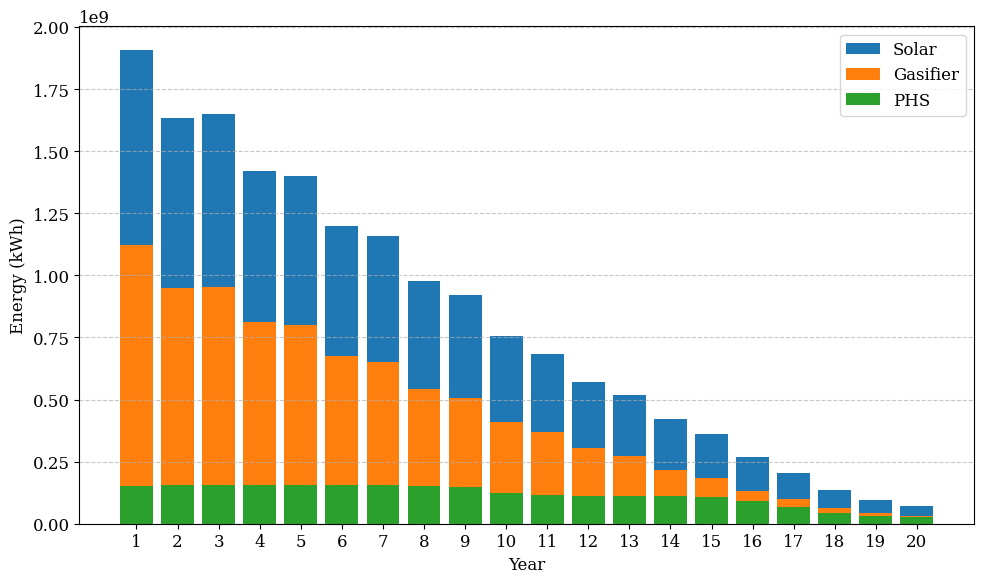

In [22]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'sol', 'gas', and 'bat' columns
# and you have already calculated yearly_solar, yearly_gasifier, and yearly_battery lists.

plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization

# Create the stacked bar chart
plt.bar(range(len(yearly_solar)), yearly_solar, label='Solar', bottom=[sum(x) for x in zip([0]*len(yearly_solar),yearly_gasifier, yearly_phs)])
plt.bar(range(len(yearly_gasifier)), yearly_gasifier, label='Gasifier', bottom=yearly_phs)
plt.bar(range(len(yearly_phs)), yearly_phs, label='PHS')

plt.xlabel("Year")
plt.ylabel("Energy (kWh)")  # Or appropriate unit
# plt.title("Yearly Energy Production by Source")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(len(yearly_solar)), [str(i + 1) for i in range(len(yearly_solar))]) # Set x-axis ticks to year numbers
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.savefig('lowres_energy_phs.png', dpi=500)
plt.show()

In [23]:
inv_cap_phs = np.array(solar_ene_array).max()
inv_phs_lcoe, inv_asc = LCOE_inv(ene_tot_phs, inv_cap_phs)
inv_phs_lcoe, inv_asc

(0.012519880886620495, 181025404.20669058)

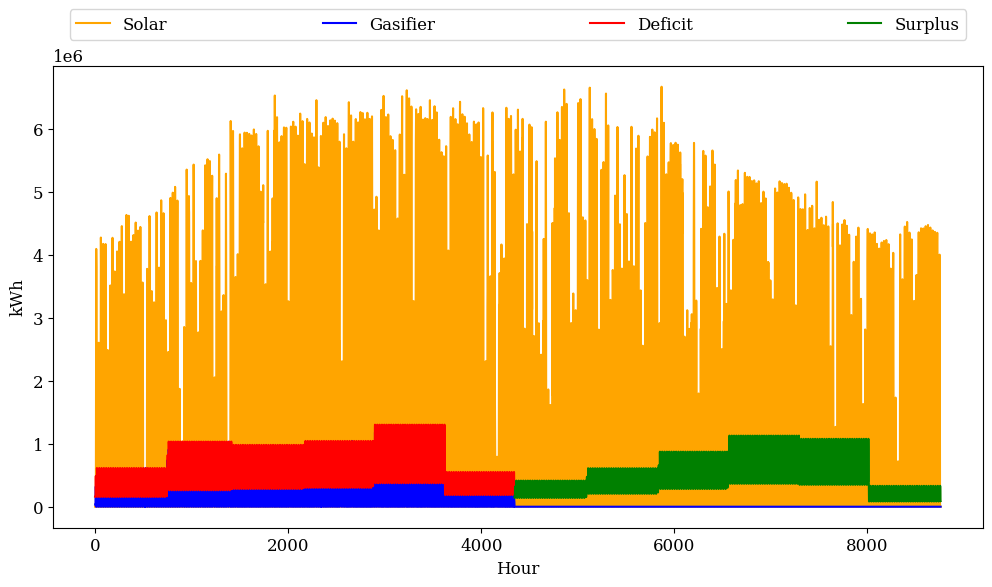

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# ... (your existing code)

i = 0 # start hour
j = 8760  # end hour
x = np.arange(i, j)

fig, ax1 = plt.subplots(figsize=(12, 6))

# ... (rest of the plotting code without the twinx and second y-axis for battery SOC)

# Plotting on the first y-axis (left)
ax1.plot(x, solar_array[i:j], label='Solar', color='orange')
ax1.plot(x, gasifier_array[i:j], label='Gasifier', color='blue')

# Separate plots for deficit and surplus
deficit_indices = np.where(np.array(deficit_array[i:j]) < 0)[0]
surplus_indices = np.where(np.array(deficit_array[i:j]) >= 0)[0]

ax1.plot(x[deficit_indices], -np.array(deficit_array[i:j])[deficit_indices], label='Deficit', color='red')
ax1.plot(x[surplus_indices], np.array(deficit_array[i:j])[surplus_indices], label='Surplus', color='green')


ax1.set_xlabel("Hour")
ax1.set_ylabel("kWh")


# Set the legend
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=1.) # Increased ncol for the legend

plt.savefig("pv_phs_gas_whole_year.png", dpi=600)
plt.show()

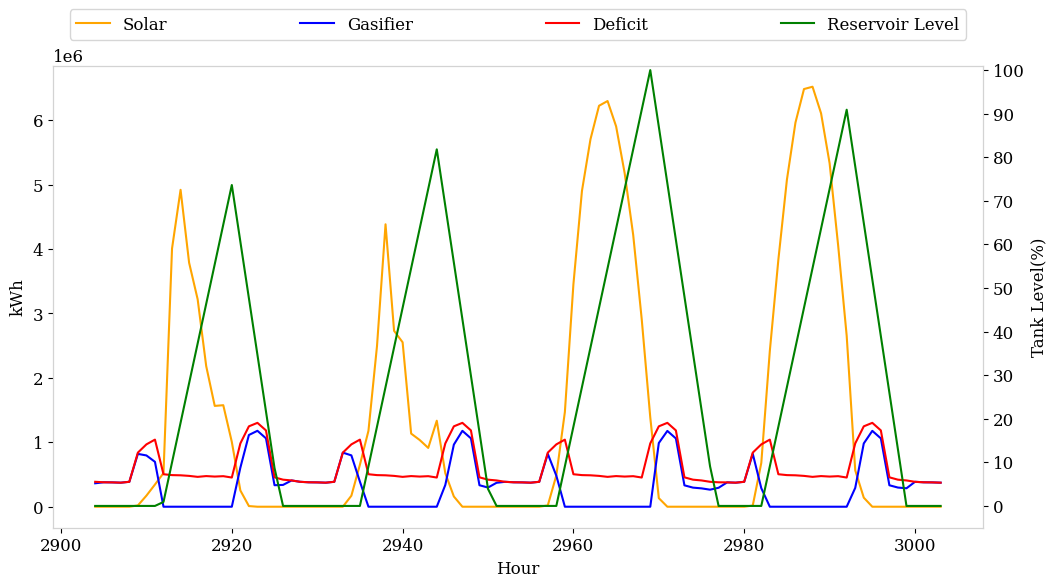

In [25]:
import matplotlib.pyplot as plt
import numpy as np

'''
Viewing the operation of the optimized hybrid energy system.
'''
# plt.figure(figsize=(12, 6))
i = 2904 # start hour
j = 2904+100 # end hour
x = np.arange(i,j)

# plt.figure(figsize=(10,8), dpi=500)
# plt.subplot(1,1,1)


fig, ax1 = plt.subplots(figsize=(12, 6))
# set_plot_style(plt.gca())
# ax = plt.gca()  # Get the current axes
ax1.spines['top'].set_color('lightgray')
ax1.spines['bottom'].set_color('lightgray')
ax1.spines['left'].set_color('lightgray')
ax1.spines['right'].set_color('lightgray')

# Plotting on the first y-axis (left)
ax1.plot(x, solar_array[i:j], label='Solar', color='orange')
ax1.plot(x, gasifier_array[i:j], label='Gasifier', color='blue')
# ax1.plot(x, turbine_array[i:j], label='Turbine Supply', color='green')
ax1.plot(x, -np.array(deficit_array[i:j]), label='Deficit', color='red')
ax1.set_xlabel("Hour")
ax1.set_ylabel("kWh")
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.grid(axis='x', linestyle='--', alpha=0.7)


# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Normalize battery array to 0-1 range
# normalized_battery = (np.array(battery_array[i:j]) - np.min(battery_array[i:j])) / (np.max(battery_array[i:j]) - np.min(battery_array[i:j]))
normalized_tank =  100*(np.array(reservoir_array[i:j]) - np.min(reservoir_array[i:j])) / (np.max(reservoir_array[i:j]) - np.min(reservoir_array[i:j]))

ax = plt.gca()  # Get the current axes
ax2.spines['top'].set_color('lightgray')
ax2.spines['bottom'].set_color('lightgray')
ax2.spines['left'].set_color('lightgray')
ax2.spines['right'].set_color('lightgray')

# Plotting on the second y-axis (right)
ax2.plot(x, normalized_tank, label='Reservoir Level', color='green')
ax2.set_ylabel("Tank Level(%)")
# ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(bottom=None, top=101) # Set the limit of the second y-axis
ax2.set_yticks(np.arange(0.0, 110, 10))


# # Combining legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2 , labels+labels2, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=5, mode="expand", borderaxespad=1.)
plt.savefig("phs-operation.png", dpi=600)
plt.show()

In [26]:
# asc pie chart
solar_phs, gasifier_phs, pump, turbine = results_phs.X

solar_asc = cost_pv(solar_phs)
gasifier_asc = cost_gasifier(gasifier_phs)
inv_phs_asc = cost_inv(inv_cap_phs)
reservoir_asc = cost_reservoir(reservoir_max)
turbine_asc = cost_turbine(turbine)
pump_asc = cost_pump(pump)

1227903962.8902388
1227903962.8902388


<Figure size 5000x4000 with 0 Axes>

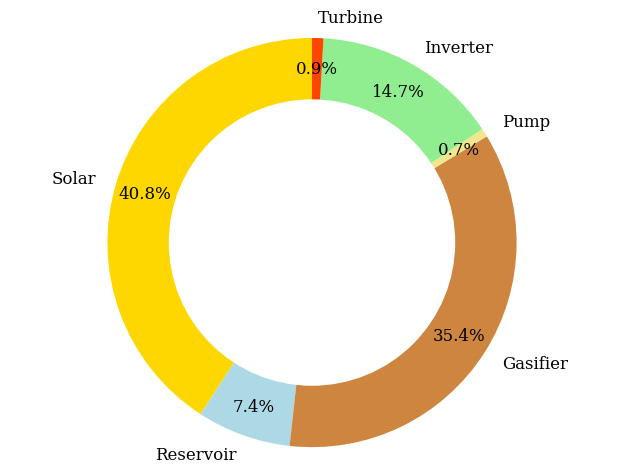

In [27]:
# Data for the pie chart
labels = ['Solar', 'Reservoir', 'Gasifier','Pump', 'Inverter', 'Turbine' ]
sizes = [solar_asc, reservoir_asc, gasifier_asc,pump_asc, inv_phs_asc, turbine_asc]
colors = ['gold', 'lightblue', 'peru', 'khaki', 'lightgreen', 'orangered']

print(asc+inv_asc)
print(solar_asc+reservoir_asc+gasifier_asc+pump_asc+inv_phs_asc+turbine_asc)
# Create the pie chart with a hole in the middle
plt.figure(figsize=(10,8), dpi=500)
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a circle in the middle to create the donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
# plt.title('Annualized System Cost Components')
plt.tight_layout()
plt.savefig('phs_ASC.png', dpi=600)
plt.show()

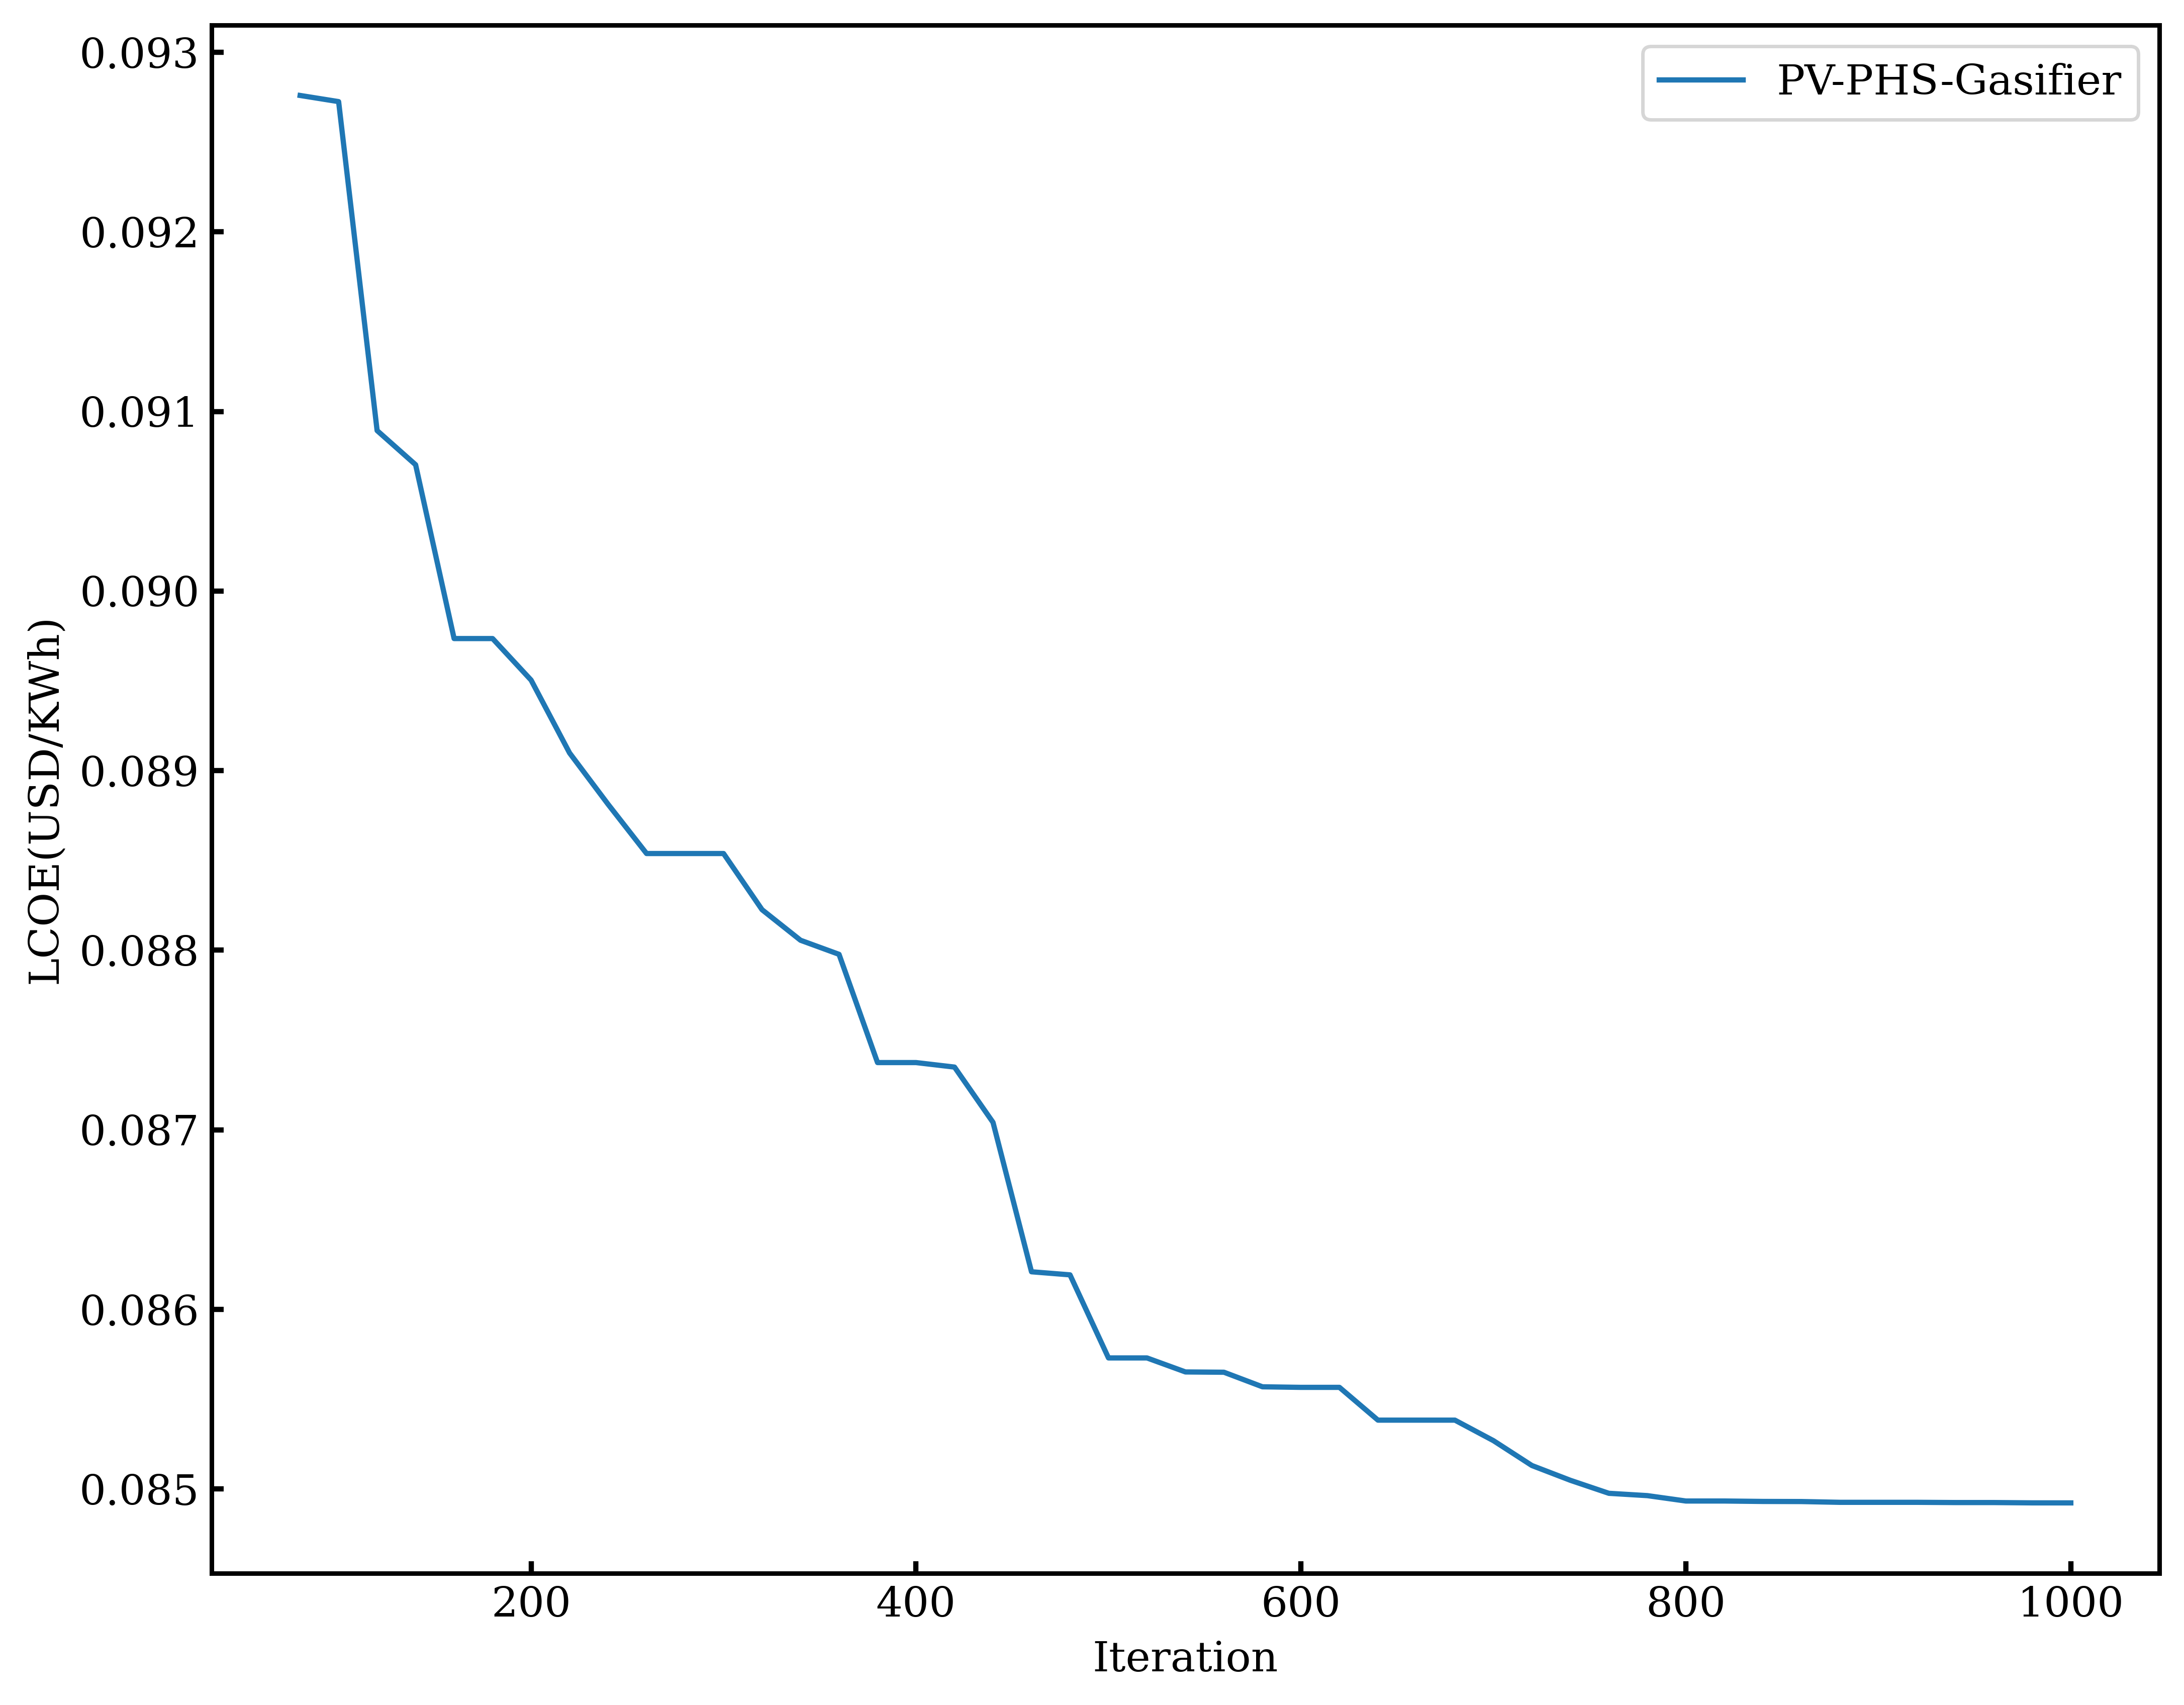

In [ ]:
'''
Convergence plot for SOO.
'''
import numpy as np
import matplotlib.pyplot as plt

# plt.title("Convergence")
plt.figure(figsize=(10,8), dpi=500)
plt.subplot(1,1,1)
set_plot_style(plt.gca())

n_evals = np.array([e.evaluator.n_eval for e in results_phs.history])
opt = np.array([e.opt[0].F for e in results_phs.history])
plt.plot(n_evals[3:], opt[3:]+inv_phs_lcoe, label = "PV-PHS-Gasifier", linestyle="-")

# n_evals = np.array([e.evaluator.n_eval for e in results_p2h2p.history])
# opt = np.array([e.opt[0].F for e in results_p2h2p.history])
# plt.plot(n_evals[3:], opt[3:]+inv_p2h2p_lcoe, label = "PV-P2H2P-Gasifier", linestyle="-")

# n_evals = np.array([e.evaluator.n_eval for e in results_bat.history])
# opt = np.array([e.opt[0].F for e in results_bat.history])
# plt.plot(n_evals[3:], opt[3:]+inv_bat_lcoe,label = "PV-Battery-Gasifier", linestyle="-")


plt.xlabel("Iteration")
plt.ylabel("LCOE(USD/KWh)")
plt.legend(loc='upper right')
# plt.savefig('phs_convergence.png')
# plt.savefig('battery_convergence.png')
plt.savefig('battery_convergence.png')
plt.show()